## Basic Exploration of Datasets

In this initial section of the notebook, the focus is on the essential data cleaning and transformation processes needed to establish a robust dataset for the mineral exploration dashboard, specifically targeting rare earth elements (REEs).

### Raster Data Preparation

The raster datasets vary in resolution from 100 meters to 1000 meters. The **1000-meter** resolution rasters, which are of geophysical interest and cover the entire British Columbia region, will be used as a baseline to resample higher-resolution rasters to this regional scale. This approach aims to enhance the identification of potential prospective zones. Additionally, a mask will be applied to handle no-data values in the higher-resolution rasters by assigning NaN, ensuring data consistency across the analysis. Throughout the project, the analysis will be conducted using the **EPSG:3153 CRS** (NAD83(CSRS) / BC Environment Albers), conducive to accurate metric calculations, with the final deliverable being converted to EPSG:4269 CRS to meet specification requirements.

### Iterative Approach and Regional Focus
- **Initial Cleaning Scope**: Initially, the data cleaning efforts will be concentrated solely on the British Columbia province. This focused approach will help us in developing the MVP (Minimum Viable Product) for the dashboard.
- **Data Sources**: We will begin with radiometric data and plan to incorporate additional variables in future iterations of the project, progressively enriching our dataset.

## Datasets

Layer Name | Details | Source |
--- | --- | --- | 
admin_boundaries | shapefile - polygons| [Goverment of Canada](https://www.sciencebase.gov/catalog/item/5ab555c6e4b081f61ab78093) | 
critical_minerals | shapefile - points  | [as above](https://open.canada.ca/data/en/dataset/22b2db8a-dc12-47f2-9737-99d3da921751/resource/47e4cbb0-e19c-47c5-9c74-b4f68448b0d4)
x | _Computed in QGIS from 1:250k geology polygons_ | [Mineral Resources ](http://www.m.) 
GRAV | Isostatic residual Bouguer anomaly -- 1000m res | [Mineral Resources ](https://www.mrt.tas.gov.au/webdoc2//tasgrav_residual.zip) 
GRAV_1VD | 1st vertical derivative -- 1000m res | as above
GRAV_A | Gravity Anomalies -- 1000m res  | as above
GRAV_HG | Horizontal Gradient -- 1000m res | as above
MAG_1VD | 1st vertical derivative of the Magnetic Field -- 200m res | [Canada](htttp://)
MAG_RMF | Residual Magnetic Field -- 200m res | as above
RAD_* | eK, eU, eTh -- 250m res| [Canada](https://data.gov.au/search?q=4th%20edition%20radiometrics)
RAD_* | eTh/K, eU/eTh, eU/eTh -- 250m res | [Canada](https://data.gov.au/search?q=4th%20edition%20radiometrics)

### Import libraries

In [11]:
import warnings
warnings.filterwarnings('ignore')

# Import functions and reload the module after making changes
from scripts import utilities
import importlib
importlib.reload(utilities)
from scripts.utilities import read_shapefile, check_transform_crs, to_geodataframe,process_and_reproject_rasters, interactive_plot_raster, convert_raster_to_float, resample_rasters_to_resolution


#General libraries
import pandas as pd
import geopandas as gpd
import os
import gc

#Raster
from osgeo import gdal, osr
import rasterio



#Plotting
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown

### Shapefiles

#### Admin boundaries
I will utilize polygons to perform "clipping" on raster datasets, initially focusing on British Columbia. This region is specifically chosen for its relevance in the database as a significant area for rare earth elements (REEs), particularly due to the Wicheeda deposit. Over time, I plan to expand the scope of the analysis to include Ontario and Quebec, the other provinces in the database known to possess REE deposits.

Please note that throughout this notebook, I will consistently use utility functions such as `read_shapefile` and `check_transform_crs` from the `utilities` module. This module serves as a central repository for commonly used functions, streamlining processes and ensuring consistency across the entire notebook.

In [2]:
path2 = r'datasets/shp/originals/admin_boundaries.shp'
admin = read_shapefile(path2)
admin=check_transform_crs(admin,'EPSG:3153')


Shapefile loaded with 13 records
Columns: 7
Geometry type: ['MultiPolygon' 'Polygon']
Transforming from EPSG:4269 to EPSG:3153.


<Axes: >

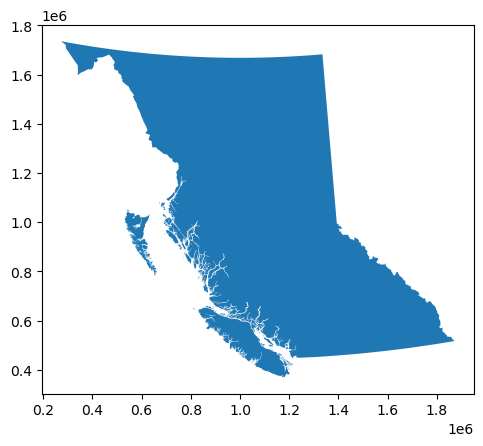

In [3]:
# target_province=admin[admin['PRENAME'].isin(['British Columbia','Nunavut','Ontario','Quebec','Yukon'])]
target_province=admin[admin['PRENAME'].isin(['British Columbia'])]#,'Ontario','Quebec'])]
target_province.plot()

#### Geology (_Polygon_), Geochronology (_Point_), Faults (_PolyLine_).
The datasets used in this section are specifically tailored for British Columbia. In order for the datasets t be ready for immediate use in our explorations, we need to ensure only relevant information is preserved.

In [4]:
bc= read_shapefile('datasets\shp\originals\BC_bedrock_ll83.shp')
bc=check_transform_crs(bc, 'EPSG:3153')
bc.drop(columns=['upid','gid','area_m2','period','era','strat_age','strat_name','gp_suite','fm_lithodm', 'mem_phase','rk_char', 'unit_desc','terrane', 'basin', 'basin_age', 'project', 'src_url', 'src_ref_s','map_comp', 'edit_date', 'pub_org'], inplace=True)
bc.head(1)

Shapefile loaded with 35424 records
Columns: 28
Geometry type: ['Polygon']
Transforming from EPSG:4269 to EPSG:3153.


,strat_unit,rock_class,rock_type,age_max,age_min,belt,geometry
0,DPBC,sedimentary rocks,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca,"POLYGON ((1036229.310 1265500.000, 1036445.940..."


In [5]:
## for simplification we will use just de general lithology unit "rock_class"
bc_rocks=bc.dissolve(by='rock_class')
bc_rocks.reset_index(inplace=True)
bc_rocks.to_file(r'datasets\shp\bc_rocks.shp')
print(f'The original geodatagrame has {bc.shape[0]} rows, the simplied geodataframe has {bc_rocks.shape[0]}\n....')

# Force garbage collection and free up memory
del bc
gc.collect()
print(f'\n......\nmemory freed')

The original geodatagrame has 35424 rows, the simplied geodataframe has 11
....

......
memory freed


In [6]:
#Geocronology
new=to_geodataframe(r'datasets\new_age.csv','WGS84-lat','WGS84-long')
# NOTE: The "Sample age" field is not numeric. Six values are ranges such as "170-180".
# It might be useful to either convert these values into a numeric format or exclude them in later steps.

Error reading the file with utf-8. Trying with 'latin1' encoding...
GeoDataFrame created with 532 records
Geometry type: ['Point']
CRS=EPSG:4269


In [7]:
new.to_file(r'datasets\shp\geochronolyBC.shp')

#### Faults


In [2]:
faults= read_shapefile('datasets\shp\originals\BC_faults_ll83.shp')
faults=check_transform_crs(faults)
faults.columns

Shapefile loaded with 57279 records
Columns: 9
Geometry type: ['LineString']
CRS is already correct.


Index(['gid', 'ulid', 'fault_type', 'confidence', 'fault_name', 'length_m',
       'edit_date', 'pub_org', 'geometry'],
      dtype='object')

In [10]:
faults['confidence'].value_counts()

confidence
inferred       6798
approximate    5063
defined        2360
assumed        1411
unknown          62
aproximate        1
Name: count, dtype: int64

#### Critical Minerales occurrences across Canada

In [6]:
## This csv file has a special condition to open it correctly, so the cleaning it will be performed here
from shapely.geometry import Point

CM = pd.read_csv('datasets/MineralOccurrenceDataBC.csv', delimiter=r'[,\t]+', engine='python') 
CM=CM.applymap(lambda x: x.strip() if isinstance(x,str) else x)
CM.head(1)

,MINFILNO,NAME1,NAME2,STATUS_C,STATUS_D,LATITUDE,LAT_DEG,LAT_MIN,LAT_SEC,LAT_HEMI,...,NTSMAP_C1,NTSMAP_C2,PRODUCTN,RESERVES,REGION_C1,REGION_D1,REGION_C2,REGION_D2,URL,Unnamed: 56
0,082FSE068,OPTION,SKY,PROS,Prospect,49.151666,49,9,6,N,...,082F01E,,N,N,BC,British Columbia,,,http://minfile.gov.bc.ca/Summary.aspx?minfilno...,NaN


The information provided is extensive and, at this stage, unnecessary for further analysis. Therefore, I retain only the columns that are relevant. A more effective approach would be to perform a join with geological data to enrich the dataset.

In [7]:
columns= [4,5,10,19,20,21,37]
CM_2=CM.iloc[:, columns].copy()

#Convert DF to GeoDF
geometry = [Point(xy) for xy in zip(CM['LONGITUDE'], CM['LATITUDE'])]
gdf = gpd.GeoDataFrame(CM_2, geometry= geometry)
gdf.set_crs(epsg=4269, inplace=True)
gdf=check_transform_crs(gdf, 'EPSG:3153')
print(f"GeoDataFrame created with {len(gdf)} records\nGeometry type: {gdf.geom_type.unique()}\nCRS={gdf.crs}")

# #Intersect CM points with BC polygons
bc_cm=gpd.sjoin(gdf,bc_rocks, how='inner', op='within')
bc_cm.head(2)

Transforming from EPSG:4269 to EPSG:3153.


GeoDataFrame created with 65 records
Geometry type: ['Point']
CRS=EPSG:3153


,STATUS_D,LATITUDE,LONGITUDE,COMMOD_C1,COMMOD_C2,COMMOD_C3,DEPTYPE_D1,geometry,index_right,rock_class,strat_unit,rock_type,age_max,age_min,belt
0,Prospect,49.151666,-116.21444,CU,AU,WO,Polymetallic veins Ag-Pb-Zn+/-Au,POINT (1712345.013 508793.306),5,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca
1,Showing,49.459722,-117.59277,NB,TA,UR,Five-element veins Ni-Co-As-Ag+/-(Bi-U),POINT (1608464.203 529884.983),0,intrusive rocks,KTgr,"granite, alkali feldspar granite intrusive rocks",Cretaceous,Tertiary,Omineca


In [34]:
bc_cm.to_file(r'datasets\shp\cmBC.shp')

### Interactivce map

In [11]:
bc_cm.columns

Index(['OBJECTID', 'OperationG', 'Operatio_1', 'PropertyNa', 'Property_1',
       'OperatorOw', 'Operator_1', 'ProvincesE', 'ProvincesF', 'Commoditie',
       'Commodit_1', 'Developmen', 'Developm_1', 'ActivitySt', 'Activity_1',
       'Latitude', 'Longitude', 'Website', 'ID', 'EA_Status', 'geometry',
       'index_right', 'rock_class', 'gid', 'upid', 'area_m2', 'strat_unit',
       'era', 'period', 'strat_age', 'strat_name', 'gp_suite', 'fm_lithodm',
       'mem_phase', 'rock_type', 'rk_char', 'unit_desc', 'age_max', 'age_min',
       'belt', 'terrane', 'basin', 'basin_age', 'project', 'src_url',
       'src_ref_s', 'map_comp', 'edit_date', 'pub_org'],
      dtype='object')

In [12]:
##Interactive map targeting CM column 
filter_values = bc_cm['Commoditie'].unique() #Here we can change any specific column we want to interact with. For now is just set to work with bc_cm gdf.
# column2_values = bc_cm['Developmen'].unique()

@interact(Filter=filter_values)
def show_map(Filter):

    fig, ax = plt.subplots(figsize=(10,10))
    
    #Rock type
    bc_rocks.plot(ax=ax, column='rock_class', legend=True, cmap='viridis')
    
    #Geocronology
    new.plot(ax=ax, color ='black', marker ='o', markersize=7, alpha=0.6)
    # Adding labels for geochronology points
    # for x, y, label in zip(new.geometry.x, new.geometry.y, new['Sample Age']):
    #     ax.text(x, y, label, fontsize=8, ha='right', color='black')

    #Filtering by value for interactive map
    data_filtered = bc_cm[bc_cm['Commoditie'] == Filter]
    data_filtered.plot(ax=ax, color='red', marker='o', markersize=10)

    ## Adding prospect points of interests
    poi = bc_cm[bc_cm['Commoditie']=='Rare earth elements']
    # x = poi.geometry.x.iloc[0]
    # y = poi.geometry.y.iloc[0]
    for x,y label in zip(poi.geometry.x,poi.geometry.y, poi['COMMOD_C2']):
        ax.text(x,y,label,fontsize=7,ha='left',color='black')


    ax.scatter(x,y, color='white', marker='*', s=70)
    ax.text(x,y,'Wicheeda', fontsize=7, ha='left', color ='white')
   

    plt.title('BC simplyfied map by rock class')
    plt.show()

interactive(children=(Dropdown(description='Filter', options=('Magnesite (fused), magnesia (products)', 'Coppe…

The CM dataset has 10 ocurrecens of critical minerals across Canada. It's the purpose to integrate those targets in the final model.

In [13]:
CM[CM['Commoditie']=='Rare earth elements'].iloc[:,7:18]

,ProvincesE,ProvincesF,Commoditie,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website
144,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca
163,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com
199,Northwest Territories,Territoires du Nord-Ouest,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,62.118060,-112.599720,https://vitalmetals.com.au
214,Newfoundland and Labrador,Terre-Neuve-et-Labrador,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,52.398330,-55.824170,Not available/Pas disponible
223,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,Active,En activité,52.140033,-106.627370,https://www.src.sk.ca/campaigns/rare-earth-pro...
224,Ontario,Ontario,Rare earth elements,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/
227,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca
230,Saskatchewan,Saskatchewan,Rare earth elements,Éléments des terres rares,Advanced processing project,Projet de traitement avancé,On hold / suspended,En attente / suspendu,52.176809,-106.656706,https://vitalmetals.com.au
232,Quebec,Québec,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com
263,British Columbia,Colombie-Britannique,Rare earth elements,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,54.531410,-122.099120,https://defensemetals.com


In [14]:
CM[(CM['Commoditie']=='Rare earth elements') & (CM['ProvincesE'].isin(['Quebec','Ontario']))].iloc[:,10:]

,Commodit_1,Developmen,Developm_1,ActivitySt,Activity_1,Latitude,Longitude,Website,ID,EA_Status,geometry
144,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,46.817470,-78.474500,http://www.qpmcorp.ca,145,None,POINT (-78.47450 46.81747)
163,Éléments des terres rares,Advanced project,Projet avancé,Active,En activité,56.945830,-68.404170,https://commerceresources.com,164,None,POINT (-68.40417 56.94583)
224,Éléments des terres rares,Demonstration plant,Usine de démonstration,Active,En activité,44.233334,-76.500000,https://ucore.com/rapidsx/,225,None,POINT (-76.50000 44.23333)
227,Éléments des terres rares,Advanced unconventional project,Projet avancé non conventionnel,Active,En activité,45.525976,-73.340812,https://geomega.ca,228,None,POINT (-73.34081 45.52598)
232,Éléments des terres rares,Advanced project,Projet avancé,On hold / suspended,En attente / suspendu,48.542770,-71.154450,https://www.magrispm.com,233,None,POINT (-71.15445 48.54277)


### Rasters
The initial focus will be on radiometric (RAD) data due to the geochemical significance of high-temperature REE mineral deposits. Additional rasters, such as gravimetry and magnetic total field, may be incorporated if their resolutions are compatible with the initial analysis.

The current raster resolution is 250m, and the data types include:
- __Equivalent Thorium (eTh)__
- __Equivalent Uranium (eU)__
- __Equivalent Potassium (K)__
- __Equivalent eTh/K__
- __Equivalent eU/eTh__
- __Equivalent eU/K__

### Raster Processing: 

- **Data Type**: I'll preprocess the original raster data by converting it from uint8 to float32. This conversion allows for the handling of NaN values, ensures greater precision for mathematical operations.

- **Reprojected & Cropped**: All rasters are reprojected to a fixed CRS (`EPSG:3153`) for better spatial resolution at British Columbia province. Due to the diverse geological characteristics of REE deposits, isolating relevant data for each type is essential. In BC, for example, the focus is on carbonatite-type deposits. The goal is to later incorporate other regions to explore potential generalizations across different deposit types.

- **Resampled**: 

Data type to float32

In [33]:
raster_paths = [os.path.join(r'datasets\raster\originals', f) for f in os.listdir(r'datasets\raster\originals') if f.lower().endswith('.tif')]
output_path = r'datasets\raster\float'

for path in raster_paths:
    convert_raster_to_float(path, output_path)

Reproject and Crop 

In [4]:
raster_paths = [os.path.join(r'datasets\raster\float', f) for f in os.listdir(r'datasets\raster\float') if f.lower().endswith('.tif')]
output_directory = r'datasets\raster\cropped_reprojected'
process_and_reproject_rasters(raster_paths, target_province, output_directory, 'EPSG:3153')

All rasters processed to CRS EPSG:3153 and cropped as specified with NaN for non-covered areas.


In [5]:
#checking metadata
def print_metadata(file_path):
    with rasterio.open(file_path) as src:
        print("CRS:", src.crs)
        print("Resolution:", src.res)
        print("Bounds:", src.bounds)
        print("Tags:", src.tags())


for filename in os.listdir(r'datasets\raster\cropped_reprojected'):
    if filename.lower().endswith(".tif"):
        file_path = os.path.join(r'datasets\raster\cropped_reprojected', filename)
        print_metadata(file_path)

CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273532.9413747679, bottom=368497.15392381465, right=1870745.4201851445, top=1736091.3726392225)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273532.9413747679, bottom=368497.15392381465, right=1870745.4201851445, top=1736091.3726392225)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273532.9413747679, bottom=368497.15392381465, right=1870745.4201851445, top=1736091.3726392225)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273532.9413747679, bottom=368497.15392381465, right=1870745.4201851445, top=1736091.3726392225)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:3153
Resolution: (252.91140807935165, 252.91140807935165)
Bounds: BoundingBox(left=273661.346551613, botto

In [6]:
# #check raster dtypes
# def check_raster_dtypes(raster_paths):
#     """
#     Checks and prints the data types of the bands in raster files.

#     Args:
#     raster_paths (list of str): Paths to the raster files.
#     """
#     for path in raster_paths:
#         with rasterio.open(path) as src:
#             print(f"Raster: {path}")
#             for i in range(1, src.count + 1):
#                 dtype = src.dtypes[i - 1]  # Obtiene el tipo de datos de la i-ésima banda
#                 print(f"  Banda {i}: {dtype}")
#             print()  # Añade una línea en blanco para separar diferentes rasters

# # Lista de rutas a tus archivos raster
# raster_paths = [os.path.join(r'datasets\raster\cropped_reprojected', f) for f in os.listdir(r'datasets\raster\cropped_reprojected') if f.lower().endswith('.tif')]
# # Llama a la función
# check_raster_dtypes(raster_paths)


Raster: datasets\raster\cropped_reprojected\cropped_reprojected_AGG_Canada 2 km - GRAV - 1st Vertical Derivative_float.tif
  Banda 1: float32
  Banda 2: float32
  Banda 3: float32

Raster: datasets\raster\cropped_reprojected\cropped_reprojected_AGG_Canada 2 km - GRAV - Gravity Anomalies_float.tif
  Banda 1: float32
  Banda 2: float32
  Banda 3: float32

Raster: datasets\raster\cropped_reprojected\cropped_reprojected_AGG_Canada 2 km - GRAV - Horizontal Gradient_float.tif
  Banda 1: float32
  Banda 2: float32
  Banda 3: float32

Raster: datasets\raster\cropped_reprojected\cropped_reprojected_AGG_Canada 2 km - GRAV - Isostatic Residual_float.tif
  Banda 1: float32
  Banda 2: float32
  Banda 3: float32

Raster: datasets\raster\cropped_reprojected\cropped_reprojected_Canada - 250m - RAD - Equivalent Thorium eTh - 2012 - Geotif_float.tif
  Banda 1: float32
  Banda 2: float32
  Banda 3: float32

Raster: datasets\raster\cropped_reprojected\cropped_reprojected_Canada - 250m - RAD - Equivalent U

Resamplig -- standarizing resolution across all rasters
Checking max - min resolution for resampling

In [7]:
def find_lowest_resolution(raster_paths):
    """
    Finds the lowest resolution (i.e., the highest pixel size) among a list of raster files.
    
    Args:
    raster_paths (list of str): Paths to the raster files.
    
    Returns:
    float: The highest pixel width and height found among the rasters.
    """
    max_pixel_size = 0
    for path in raster_paths:
        with rasterio.open(path) as src:
            pixel_size = src.res[0]  # Assuming square pixels, x resolution
            if pixel_size > max_pixel_size:
                max_pixel_size = pixel_size
    return max_pixel_size


raster_paths = [os.path.join(r'datasets\raster\cropped_reprojected', f) for f in os.listdir(r'datasets\raster\cropped_reprojected') if f.lower().endswith('.tif')]
lowest= find_lowest_resolution (raster_paths)
lowest

1011.5341854403905

In [23]:
# import rasterio
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# from rasterio.enums import Resampling
# from rasterio import Affine

# def resample_rasters_to_resolution(raster_paths, output_directory, target_resolution):
#     """
#     Resamples a list of raster files to a specified resolution.
    
#     Args:
#     raster_paths (list of str): Paths to the raster files.
#     output_directory (str): Directory where the resampled rasters will be saved.
#     target_resolution (float): The target pixel size to resample all rasters to.
#     """
#     for path in raster_paths:
#         with rasterio.open(path) as src:
#             # Calculate the scale factor
#             scale = src.res[0] / target_resolution
            
#             # Calculate new dimensions
#             new_width = int(src.width * scale)
#             new_height = int(src.height * scale)
            
#             # Define transformation and metadata for output
#             kwargs = src.meta.copy()
#             kwargs.update({
#                 'width': new_width,
#                 'height': new_height,
#                 'transform': rasterio.Affine(target_resolution, 0, src.bounds.left,
#                                              0, -target_resolution, src.bounds.top)
#             })
            
#             resampled_path = f"{output_directory}/resampled_{os.path.basename(path)}"
#             with rasterio.open(resampled_path, 'w', **kwargs) as dst:
#                 for i in range(1, src.count + 1):
#                     reproject(
#                         source=rasterio.band(src, i),
#                         destination=rasterio.band(dst, i),
#                         src_transform=src.transform,
#                         src_crs=src.crs,
#                         dst_transform=kwargs['transform'],
#                         dst_crs=src.crs,
#                         resampling=Resampling.bilinear  # Choose resampling method (bilinear for continuous data)
#                     )
#     print("All rasters have been resampled to the specified resolution.")


In [12]:
raster_paths = [os.path.join(r'datasets\raster\cropped_reprojected', f) for f in os.listdir(r'datasets\raster\cropped_reprojected') if f.lower().endswith('.tif') and f.lower().startswith('cropped_')]
output_directory = r'datasets\raster\resampled'

resample_rasters_to_resolution(raster_paths, output_directory, lowest)

All rasters have been resampled to the specified resolution.


In [13]:
#Checking resampling
for filename in os.listdir(r'datasets\raster\resampled'):
    if filename.lower().endswith(".tif"):
        file_path = os.path.join(r'datasets\raster\resampled', filename)
        print_metadata(file_path)

###NICE!! We are finally fine to go! ##

CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273532.9413747679, bottom=368497.15392381465, right=1870745.4201851445, top=1736091.3726392225)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273532.9413747679, bottom=368497.15392381465, right=1870745.4201851445, top=1736091.3726392225)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273532.9413747679, bottom=368497.15392381465, right=1870745.4201851445, top=1736091.3726392225)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273532.9413747679, bottom=368497.15392381465, right=1870745.4201851445, top=1736091.3726392225)
Tags: {'AREA_OR_POINT': 'Area'}
CRS: EPSG:3153
Resolution: (1011.5341854403905, 1011.5341854403905)
Bounds: BoundingBox(left=273661.346551613, botto

## Plotting layers

By default, the first TIFF file found in the directory will be plotted, and additional rasters can be selected using the dropdown menu, which will append them to the end of the output.


In [41]:
bc_cm[bc_cm['COMMOD_C1']=='RS']

,STATUS_D,LATITUDE,LONGITUDE,COMMOD_C1,COMMOD_C2,COMMOD_C3,DEPTYPE_D1,geometry,index_right,rock_class,strat_unit,rock_type,age_max,age_min,belt
18,Showing,50.926110,-118.39249,RS,LA,ND,Carbonatite-hosted deposits,POINT (1533321.934 685538.979),3,metamorphic rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Late Devonian,Late Permian,Intermontane
19,Showing,50.841666,-118.10805,RS,TH,UR,,POINT (1554227.408 678377.172),5,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca
38,Showing,51.148333,-116.36777,RS,YR,NB,,POINT (1671122.954 727332.681),5,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca
56,Showing,55.600000,-124.02611,RS,YR,,Rare element pegmatite - NYF family,POINT (1124092.749 1179933.558),3,metamorphic rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Late Devonian,Late Permian,Intermontane
61,Showing,56.466111,-123.74916,RS,CE,ND,Carbonatite-hosted deposits,POINT (1138425.423 1277066.058),5,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca
64,Showing,58.710833,-127.51055,RS,YR,,,POINT (912433.048 1526060.694),5,sedimentary rocks,DPBC,"mudstone, siltstone, shale fine clastic sedime...",Upper Devonian,Permian,Omineca


prueba codigo thinkonwad

In [ ]:
import numpy as np
raster_paths =  [os.path.join(r'datasets\raster\resampled', f) for f in os.listdir(r'datasets\raster\resampled') if f.lower().endswith('.tif')]

tif_files = [file for file in raster_paths]# if file.lower().endswith('.tif')]
n_cols = 3
n_rows = int(np.ceil(len(tif_files)/n_cols))


fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,8))


for i, ax in enumerate(axes.flatten()):
    if i < len(tif_files):
        fn = tif_files[i]
        #print(fn)
        with rasterio.open(f'{fn}', 'r') as src:
            # read spatial information
            transform = src.transform
            region = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
            # read band 1 data
            d = src.read(1)
            # nodata_mask = d == src.nodata
            # d[nodata_mask] = np.nan

            #print(d.shape)
            ax.imshow(d, vmin=np.nanpercentile(d, 5), vmax=np.nanpercentile(d, 95), extent=region)
           
            #adjusting title for each layer
            title = os.path.splitext(os.path.basename(fn))[0]
            
            title = title.replace(f"_USCa_only_", "bc")
            title = title.replace(f"_only_bc", "")
            title = title.replace(f"USCanada", "")
            title = title.replace(f"_resampled", "")
            ax.set(title = title)
            gdf.plot(ax=ax, marker='*', facecolor='r')
    else:
        ax.axis('off')
        
plt.tight_layout()         
plt.show()


In [ ]:
REE = bc_cm[bc_cm['COMMOD_C1']=='RS']
# Example usage of the function with a directory and the point of interest loaded as GeoDataFrame
interactive_plot_raster(r"datasets/raster/resampled", REE)